### Aspect Based Sentiment Analysis on the Movie Reviews, DoD Remarks and Movie Plots

In [1]:
# import libraries and dependencies
import pandas as pd
import aspect_based_sentiment_analysis as absa
import re
import plotly.express as px
from dateutil.relativedelta import relativedelta
from functools import reduce

#pd.set_option("display.max_colwidth", 1000)
#pd.set_option('display.max_rows', 700)

import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In this notebook, we will do an aspect based sentiment analysis on the movie reviews, DoD remarks, and movie plots. 

Aspect Based Sentiment Analysis (ABSA) is a technique that takes into consideration the terms related to the aspects and identifies the sentiment associated with each aspect. 

ABSA model requires aspect categories and its corresponding aspect terms to extract sentiment for each aspect from the text corpus. Typical ABSA requires labeled data containing aspect terms and aspect categories for each statement along with its sentiment score. However, it can be solved using the unsupervised approach without having labeled data and a list of aspect terms. For example, what was the overall opinion of the people who watched a movie? This analysis will help us to understand how is the public's opinion on the movie that DoD supported or not supported assistance.

Below we will implement ABSA using a modern NLP package ([Aspect Based Sentiment Analysis](https://github.com/ScalaConsultants/Aspect-Based-Sentiment-Analysis)) built for more general ABSA cases.

Following are the implementation steps:
- Data preparation
- Sentiment analysis for movies' reviews and plots and DoD remarks

### 1. Dataset preparation 
We have extracted the movie reviews using IMDb package programmatically as done in this [notebook](../notebooks/scrape_reviews.ipynb). Apart from reviews data, IMDb also provides other details such as date, userids, helpful score, etc. 

In [2]:
# read reviews data
df_reviews = pd.read_csv("../data/sentiment_analysis_data/df_reviews.csv", usecols=['content', 'date', 'idmb_id'])
df_reviews.head()

,content,date,idmb_id
0,I accidently came across this movie while surf...,24 June 2000,tt0133231
1,"This is a tearjerker, and knowing that this is...",14 April 2007,tt0133231
2,This is one of those movies that will probably...,20 December 2002,tt0133231
3,This is one of my favorite movies in the past ...,4 August 2001,tt0133231
4,"The movie is pretty good, and relatively accur...",1 January 2019,tt0133231


Let's also read our main dataset and join with the review dataset.

In [3]:
# read movie_data and join it with review data
# read the final aggregated movie data with additional information 
movie_data = pd.read_csv("../data/with_additional_data/military_hollywood_with_additional_data.csv")
movie_data['Media Type'].replace({'OTH': 'TV'}, inplace=True)
movie_data.drop(['directors'], axis=1, inplace=True)
movie_data = movie_data[['Title', 'IMDB_ID', 'Status', 'Media Type', 'Remarks', 'Year', 'genre', 'plot', 'release_date']]
movie_data.head()

,Title,IMDB_ID,Status,Media Type,Remarks,Year,genre,plot,release_date
0,"""1968""",Never Made,OTH,FILM,THE FILM STARTED OUT VERY NEGATIVE FOR THE ARM...,NaN,NaN,NaN,NaN
1,"1,000 MEN AND A BABY",tt0133231,APP,TV,VERY POSITIVE DEPICTION OF NAVY IN THIS KOREAN...,1997.0,Drama,A baby in a foreign land is adopted by the men...,07 Dec 1997
2,1ST FORCE,Never Made,OTH,FILM,INITIALLY DOD AND USMC WERE INCLINED TO SUPPOR...,NaN,NaN,NaN,NaN
3,24,tt0502209,APP,TV,APPROVED FILMING FOR ONE DAY WITH TWO MARINE C...,2004.0,"Action, Crime, Drama, Thriller",Jack and Tony clash as they wait for the time ...,11 May 2004
4,3RD DEGREE,tt0098469,APP,TV,PERSONNEL APPEARED ON THIS GAME SHOW AT THE EX...,1989.0,"Crime, Drama, Thriller",Scott Weston is a private investigator who is ...,28 May 1989


In [4]:
merged = df_reviews.merge(movie_data, left_on='idmb_id', right_on='IMDB_ID', how='outer')
no_reviews = merged[(merged.content.isna()) & ((merged.IMDB_ID!='Never Made') & (merged.IMDB_ID.notna()))].reset_index(drop=True)
no_reviews.head()

,content,date,idmb_id,Title,IMDB_ID,Status,Media Type,Remarks,Year,genre,plot,release_date
0,NaN,NaN,NaN,ABOVE THE CLOUDS,tt0024811,APP,FILM,"NAVY PROVIDED USE OF BATTLESHIPS, SUBMARINES, ...",1933.0,"Action, Adventure, Drama, Romance",Another story of the newsreel cameramen and th...,13 Dec 1933
1,NaN,NaN,NaN,AIR WOLF,tt0507183,DEN,TV,AIR FORCE ADVISED PRODUCTION THAT ASSISTANCE W...,1987.0,"Action, Adventure, Sci-Fi, Thriller",While returning from the Soviet Union with cla...,30 Jan 1987
2,NaN,NaN,NaN,ALL-STAR SALUTE TO OUR TROOPS,tt1193546,APP,TV,THE DEPARTMENT OF DEFENSE APPROVED THE PROJECT...,1991.0,"Comedy, Music",Gala homecoming celebration for the troops ret...,03 Apr 1991
3,NaN,NaN,NaN,"AMERICA, YOU'RE TOO YOUNG TO DIE",tt12220558,APP,TV,LIMITED ASSISTANCE WAS APPROVED. IT WAS NO COS...,1986.0,"Short, Documentary",An historical and patriotic film focusing on t...,NaN
4,NaN,NaN,NaN,ANGEL‘S FLIGHT,tt13891322,APP,FILM,APPROVED BY THE DEPARTMENT AFTER BEING REVIEWE...,NaN,NaN,NaN,NaN


In [5]:
print('In total there are {} records and {} unique movies where there is no review.'.format(no_reviews.shape[0], len(set(no_reviews.IMDB_ID))))

In total there are 102 records and 102 unique movies where there is no review.


In [6]:
yes_reviews = merged[merged.content.notna()].reset_index(drop=True)
yes_reviews.head()

,content,date,idmb_id,Title,IMDB_ID,Status,Media Type,Remarks,Year,genre,plot,release_date
0,I accidently came across this movie while surf...,24 June 2000,tt0133231,"1,000 MEN AND A BABY",tt0133231,APP,TV,VERY POSITIVE DEPICTION OF NAVY IN THIS KOREAN...,1997.0,Drama,A baby in a foreign land is adopted by the men...,07 Dec 1997
1,"This is a tearjerker, and knowing that this is...",14 April 2007,tt0133231,"1,000 MEN AND A BABY",tt0133231,APP,TV,VERY POSITIVE DEPICTION OF NAVY IN THIS KOREAN...,1997.0,Drama,A baby in a foreign land is adopted by the men...,07 Dec 1997
2,This is one of those movies that will probably...,20 December 2002,tt0133231,"1,000 MEN AND A BABY",tt0133231,APP,TV,VERY POSITIVE DEPICTION OF NAVY IN THIS KOREAN...,1997.0,Drama,A baby in a foreign land is adopted by the men...,07 Dec 1997
3,This is one of my favorite movies in the past ...,4 August 2001,tt0133231,"1,000 MEN AND A BABY",tt0133231,APP,TV,VERY POSITIVE DEPICTION OF NAVY IN THIS KOREAN...,1997.0,Drama,A baby in a foreign land is adopted by the men...,07 Dec 1997
4,"The movie is pretty good, and relatively accur...",1 January 2019,tt0133231,"1,000 MEN AND A BABY",tt0133231,APP,TV,VERY POSITIVE DEPICTION OF NAVY IN THIS KOREAN...,1997.0,Drama,A baby in a foreign land is adopted by the men...,07 Dec 1997


In [7]:
print('In total there are {} records and {} unique movies where there is at least a review.'.format(yes_reviews.shape[0], len(set(yes_reviews.IMDB_ID))))

In total there are 11823 records and 681 unique movies where there is at least a review.


### 1.1. Data cleaning

We shall define a function to clean the text for reviews, remarks, and plot in order to be able to apply ABSA on them.

After examining the textual data (DoD remarks, movie reviews, and movie plots) that we are interested in, we summarised the necessary data-preprocessing below:

- Removes url from the text
- 'US', 'U.S', 'U.S.', 'US.' convert all of them to U.S. if they refer to the United States
    - such as 'THE U.S GOVERNMENT', 'THE US. MILITARY', 'STILL HIGHLY POSITIVE IMAGES OF US.' 
- Replace '—' with '-'
- Change all the specific names of military supports' materials to general case: like KC-10,B-2 AND F-16 
- Special characters which will be replaced with an empty (''):
    - '{'
    - '}'
    - '['
    - ']'
    - '('
    - ')'
    - '#'
    - '~'
    - '”'
    - '“'
    - '"'
    - '|'
- Special characters which will be replaced with a space (' '):
    - '~-'
    - '-~'
    - '--'
    - ' - '
    - '='
- Some special characters/strings need to be changed with corresponding:
    - '%': ' percent'
    - 'F/A': 'FA'
    - '/': 'or'
    - '9-17-92': '17SEP1992'
    - '&': 'and'
    - '+': ' plus'
    - '‘': "'"
    - '’': "'"
    - '’': "'"
- Convert the dates like '15-NOV-1983' without '-' in it: i.e. '15NOV1983' 
- Convert the dates like '15 NOV 1983' without ' ' like : '15NOV1983' 
- Replace '-' from text like 'MINI-SERIES' or 'MINI -SERIES' with a space' ': i.e. 'MINI SERIES' or 'MINI  SERIES'
- Remove ' - ' from "text - text" like 'CRUME - BUM' while combining two texts only with a space: i.e. 'CRUME BUM'
- Make lowercase all the charachters
- Remove multiple spaces with only one space (' ')

While doing the pre-processing, we decided to keep some characters as is. For example, examples below with '-' 
- 'MAY 18-19, 2002 AT NAVAL AIR', 'BUT WITH 9-10 MINS OF NAVY COMMERCIAL', 'BECAME A 30-HOUR', 'IT WAS SET 20-30 YEARS IN THE FUTURE', '14-21 MAY', 'AS APPOXIMATELY JANUARY 3 - 31, 2004', 'SHOOTING TOOK PLACE 28 FEB - 7 MARCH'

Last but not least, we didn't want to remove the punctuation. Since when we apply the NLP models both in Sentiment Analysis and Named Entity Recognition, the NLP model will handle the punctuation. Additionally, we didn't also want to remove the stopwords since removing them could change the way of interpretation in the sentiment analysis, hence the model performance.

In [8]:
replacements = {'{': '', '}': '','[': '',']': '','(': '',')': '',  '~-': ' ', "-~":' ', '=':' ', '~': '', '#': '','%': ' percent','F/A': 'FA',
                '/': ' or ','--': ' ','”': '', '“': '', '"': '','9-17-92': '17SEP1992','&': 'and','+': ' plus','|': '','‘': "'",'’': "'",'’': "'"}

def clean_text(data, column_name):
    """
    It takes a dataframe and a column name and cleans the given attributes in place.
    data: a dataframe
    column_name: column name written as string in the given data frame 
    """
    # url removes
    data[column_name] = data[column_name].apply(lambda x: re.sub(r'(https|http)?:\/(\w|\.|\/|\?|\=|\&|\%)*\b','', str(x), re.UNICODE))
    data[column_name] = data[column_name].apply(lambda x: re.sub(r'www\.\S+\.com','', x, re.UNICODE))
    
    # keep a general U.S. name in all the text   
    data[column_name] = data[column_name].apply(lambda x: re.sub(r'((THE|the|The) [uU]{1}[sS]{1}\. )|((THE|the|The) [uU]{1}\.)([sS]{1} )', 'THE U.S. ', x, re.UNICODE))
    data[column_name] = data[column_name].apply(lambda x: re.sub(r'US CAPITOL', 'U.S. CAPITOL', x, re.UNICODE))
    data[column_name] = data[column_name].apply(lambda x: re.sub(r'(IN|TO) US\.', r'\1'+' U.S.', x, re.UNICODE))
    data[column_name] = data[column_name].apply(lambda x: re.sub(r'US\. (MILITARY|ARMY|SUBMARINES|STATE)', 'U.S. '+r'\1', x, re.UNICODE))
    data[column_name] = data[column_name].apply(lambda x: re.sub(r'OF US\.', 'OF U.S.', x, re.UNICODE))
    
    # replace the '—' with '-'
    data[column_name] = data[column_name].apply(lambda x: re.sub(r'\—', '-', x, re.UNICODE))

    # Change all the specific names of military supports' materials to general case
    data[column_name] = data[column_name].apply(lambda x: re.sub(r'\s([a-zA-Z]*)\-\d+', r" \1", x, re.UNICODE))
    
    # apply replacements
    data[column_name] = data[column_name].apply(lambda x: re.sub('({})'.format('|'.join(map(re.escape, replacements.keys()))), lambda m: replacements[m.group()], x))

    # convert the dates like 15-NOV-1983 without '-' like : 15NOV1983 
    data[column_name] = data[column_name].apply(lambda x: re.sub(r'(\d+)\-(\w+)\-(\d+)', r"\1\2\3", x, re.UNICODE))
    
    # convert the dates like 15 NOV 1983 without ' ' like : 15NOV1983 
    data[column_name] = data[column_name].apply(lambda x: re.sub(r'(\d+) (\w+) (\d+)', r"\1\2\3", x, re.UNICODE))
    
    # remove '-' from "text-" or "-text" like MINI-SERIES -> MINI SERIES or MINI -SERIES -> MINI SERIES
    data[column_name] = data[column_name].apply(lambda x: re.sub(r'([a-zA-Z]{1,})\-', r"\1 ", x, re.UNICODE))
    data[column_name] = data[column_name].apply(lambda x: re.sub(r'\s\-([a-zA-Z]{1,})', r" \1", x, re.UNICODE))
    
    # remove ' - ' from "text - text" like CRUME - BUM -> CRUME BUM
    data[column_name] = data[column_name].apply(lambda x: re.sub(r'([a-zA-Z]) \- ([a-zA-Z])', r"\1 \2", x, re.UNICODE))

    # lowercase
    data[column_name] = data[column_name].str.lower()
 
    # remove multiple space with only one
    data[column_name]= data[column_name].apply(lambda x: re.sub(r' +', ' ',  x, re.UNICODE))

    return data

In [9]:
# apply the clean_text function on our dataset step by step for 3 textual columns we are interested in
yes_reviews = clean_text(yes_reviews, 'plot') # for movies' plots
yes_reviews = clean_text(yes_reviews, 'Remarks') # for DoD remarks
yes_reviews = clean_text(yes_reviews, 'content') # for movies' reviews

In [10]:
pd.DataFrame(yes_reviews['plot'].drop_duplicates().head())

,plot
0,a baby in a foreign land is adopted by the men on a u.s. navy ship and brought to america.
8,jack and tony clash as they wait for the time of hostage exchange with saunders. senator keeler confronts president palmer about the milliken cover up while wayne initiates a secret operation against sherry.
14,scott weston is a private investigator who is supposedly hired by a rich businessman to determine whether or not his beautiful wife is fooling around behind his back. during the course of his investigation weston begins his own steamy affair with the wife. the husband then turns up dead and weston becomes a prime suspect. did he do it? has he been set up? or is he the victim of a third degree burn?
25,"adam is a 27 year old writer of radio programs and is diagnosed with a rare form of spinal cancer. with the help of his best friend, his mother, and a young therapist at the cancer center, adam learns what and who the most important things in his life are."
50,"diplomats, soldiers and other representatives of a dozen nations fend off the siege of the international compound in peking during the 1900 boxer rebellion. the disparate interests unite for survival despite competing factions, overwhelming odds, delayed relief and tacit support of the boxers by the empress of china and her generals."


In [11]:
pd.DataFrame(yes_reviews['Remarks'].drop_duplicates().head())

,Remarks
0,very positive depiction of navy in this korean war era period made for tv movie. approved filming aboard amphibious carrier as jeep carrier of the period.
8,"approved filming for one day with two marine corps fa 18 aircraft to simulate attacking and destroying a terrorist helicopter that was threatening the main character, federal agent jack bauer played by keifer sutherland."
14,personnel appeared on this game show at the expense of the production co.
25,never was officially submitted to dod. it was stopped before it got to the department no reason for support was ever forthcoming.
50,period piece about marines in china during the boxer rebellion


In [12]:
pd.DataFrame(yes_reviews['content'].drop_duplicates().head())

,content
0,"i accidently came across this movie while surfing the satellite channels the other day in england the movie was called narrow escape i wasn't going to watch it but nothing else was playing at 7am so i settled down to watch. i was glad that i did. i'm a bit of a sucker for a soppy tear jerker especially about kidsand i thought that some of the performances would have done justice to a big budget blockbuster. of course hollywood dressed up the truth a bit and added a bit more sap than was necessary, but the story shone out and i was deeply touched by it.so touched in fact that i began to search the internet for details on the ship, the men and young danny. i was a little disappointed that i couldn't find any sites with a reference to them. i hope someone rectifies that situation soon.i loved the movie"
1,"this is a tearjerker, and knowing that this is based on fact makes it all the better. we need more uplifting films such as this for the family in this day and age. so often, our military is shown in such a bad light, and it is so refreshing for them to be shown as the heroes they are. this is a wonderful, wonderful film that everyone should watch, especially as a family. this film lets us know how wonderful the military can be, and what the family can be like. sadly, we don't have television movies out anymore, thanks to horrid 'reality' shows. i wish tvms like this came out more often. i miss them. please . . . put this on dvd."
2,this is one of those movies that will probably some day be a classic. it is the incredible true story of a navy rescue of a newborn baby at the end of the korean war. this christmas story helps you to realize there are some good people out there that don't mind sacrificing for a good cause. richard thomas does an outstanding job playing the part of dr. hugh keenan who gently nurses back to health an abandoned baby as the crew of the point cruise seeks to find a good home for the child. although the movie may rank a pg rating for some brief scenes of war casualties. it overall is a great movie that the whole family can enjoy. this is one of my absolute favorite christmas movies and i can't wait to purchase my own copy.
3,"this is one of my favorite movies in the past 10 years. a wonderful true story that causes us to think about what is really important in life. the efforts of the 1,000 men to help an abandoned baby are very heart warming and encouraging. this is a great family movie that everyone can enjoy without foul language and nudity. this movie deserves an a plus all the way around."
4,"the movie is pretty good, and relatively accurate as i grew up hearing it from my late father. ps 5 rayo claudius holston served on the cve 119 uss point cruz from its commission in the pacific northwest through its fittings and paces and through the korean war. it was the proudest part of his life and the saving of saby san was one of his most memorable events along with captain hayward holding captains mast in a japanese bar for my dad. the movie aired on tv when i was home from college, my father got so excited i thought he had won the lottery. the crew has reunions almost every year and baby san is the guest of honor at almost every one. there is still a strong bond between the crew and the dr.d. holston"


### 2. Aspect Based Sentiment Analysis

Applying sentiment analysis only wouldn't give us much understanding of the context. Hence, we decided to apply [Aspect Based Sentiment Analysis](https://github.com/ScalaConsultants/Aspect-Based-Sentiment-Analysis) python package, ABSA in short, in which the model takes into consideration of the context as well.

We will try to get the sentiment (neutral/negative/positive) of textual data on the following 6 aspects:
- military
- army
- air force
- navy
- war
- marine corps

Each SentimentScore columns in the analysis below show the sentiment score of neutral/negative/positive respectively. And OverallSentiment columns is the overall sentiment assigned by the ABSA model to the corresponding text, i.e. plot or remarks. 0: neutral, 1: negative, and 2: positive.

### 2.1. ABSA for movies' plots

In [13]:
plot_data = yes_reviews[['idmb_id', 'plot']].copy().drop_duplicates().reset_index(drop=True)
plot_data.shape

(681, 2)

The code below is commented out since we only needed to run it for once to have the aspect based sentiment analysis.

In [1]:
# # Creating additional columns containing sentiments' scores and overall sentiment 
# sentiment_military=[]
# sentiment_military_score=[]
# sentiment_army=[]
# sentiment_army_score=[]
# sentiment_air_force=[]
# sentiment_air_force_score=[]
# sentiment_navy=[]
# sentiment_navy_score=[]
# sentiment_war=[]
# sentiment_war_score=[]
# sentiment_marine=[]
# sentiment_marine_score=[]
# 
# nlp = absa.load()
# for i in plot_data['plot'].values:
#     military, army, air_force, navy, war, marine = nlp(i, aspects=["military", "army", "air force", "navy", "war", "marine corps"])
#     sentiment_military.append(military.sentiment)
#     sentiment_military_score.append(military.scores)
#     sentiment_army.append(army.sentiment)
#     sentiment_army_score.append(army.scores)
#     sentiment_air_force.append(air_force.sentiment)
#     sentiment_air_force_score.append(air_force.scores)
#     sentiment_navy.append(navy.sentiment)
#     sentiment_navy_score.append(navy.scores)
#     sentiment_war.append(war.sentiment)
#     sentiment_war_score.append(war.scores)
#     sentiment_marine.append(marine.sentiment)
#     sentiment_marine_score.append(marine.scores)
#     
# plot_data['SentimentScore Military']=sentiment_military_score
# plot_data['OverallSentiment Military']=sentiment_military
# plot_data['SentimentScore Army']=sentiment_army_score
# plot_data['OverallSentiment Army']=sentiment_army
# plot_data['SentimentScore AirForce']=sentiment_air_force_score
# plot_data['OverallSentiment AirForce']=sentiment_air_force
# plot_data['SentimentScore Navy']=sentiment_navy_score
# plot_data['OverallSentiment Navy']=sentiment_navy
# plot_data['SentimentScore War']=sentiment_war_score
# plot_data['OverallSentiment War']=sentiment_war
# plot_data['SentimentScore Marine']=sentiment_marine_score
# plot_data['OverallSentiment Marine']=sentiment_marine

In [15]:
plot_data.head()

,idmb_id,plot,SentimentScore Military,OverallSentiment Military,SentimentScore Army,OverallSentiment Army,SentimentScore AirForce,OverallSentiment AirForce,SentimentScore Navy,OverallSentiment Navy,SentimentScore War,OverallSentiment War,SentimentScore Marine,OverallSentiment Marine
0,tt0133231,a baby in a foreign land is adopted by the men on a u.s. navy ship and brought to america.,"[0.8247396, 0.13339587, 0.04186457]",0,"[0.7430444, 0.24107182, 0.015883826]",0,"[0.7798408, 0.18095426, 0.03920492]",0,"[0.6571965, 0.040527545, 0.30227596]",0,"[0.98606724, 0.0058916346, 0.008041187]",0,"[0.9303554, 0.021828009, 0.047816604]",0
1,tt0502209,jack and tony clash as they wait for the time of hostage exchange with saunders. senator keeler confronts president palmer about the milliken cover up while wayne initiates a secret operation against sherry.,"[0.7479575, 0.24099207, 0.011050422]",0,"[0.6256231, 0.36075652, 0.013620362]",0,"[0.80217564, 0.17280221, 0.025022171]",0,"[0.6772173, 0.30567646, 0.017106257]",0,"[0.9815597, 0.012521648, 0.0059186816]",0,"[0.86357564, 0.12261746, 0.013806902]",0
2,tt0098469,scott weston is a private investigator who is supposedly hired by a rich businessman to determine whether or not his beautiful wife is fooling around behind his back. during the course of his investigation weston begins his own steamy affair with the wife. the husband then turns up dead and weston becomes a prime suspect. did he do it? has he been set up? or is he the victim of a third degree burn?,"[0.55728775, 0.43449834, 0.0082138935]",0,"[0.39967117, 0.5924298, 0.007899052]",1,"[0.73411053, 0.258969, 0.00692043]",0,"[0.3303997, 0.65468377, 0.014916555]",1,"[0.76878303, 0.22436151, 0.00685547]",0,"[0.7803574, 0.21181677, 0.007825842]",0
3,tt1306980,"adam is a 27 year old writer of radio programs and is diagnosed with a rare form of spinal cancer. with the help of his best friend, his mother, and a young therapist at the cancer center, adam learns what and who the most important things in his life are.","[0.39714688, 0.57559335, 0.027259756]",1,"[0.21364443, 0.7602861, 0.026069522]",1,"[0.50071293, 0.44963667, 0.04965041]",0,"[0.22167109, 0.70370924, 0.074619636]",1,"[0.4547838, 0.4803691, 0.06484714]",1,"[0.63902485, 0.32487765, 0.036097527]",0
4,tt0056800,"diplomats, soldiers and other representatives of a dozen nations fend off the siege of the international compound in peking during the 1900 boxer rebellion. the disparate interests unite for survival despite competing factions, overwhelming odds, delayed relief and tacit support of the boxers by the empress of china and her generals.","[0.64569944, 0.048342817, 0.30595773]",0,"[0.7599341, 0.0836921, 0.15637372]",0,"[0.2669839, 0.35400975, 0.3790063]",2,"[0.27620423, 0.38636547, 0.33743036]",1,"[0.4458001, 0.015462775, 0.5387371]",2,"[0.23878594, 0.5417204, 0.21949366]",1


In [16]:
# save the plot data where ABSA applied to a csv file 
plot_data.to_csv('../data/sentiment_analysis_data/plot_data.csv')

### 2.2. ABSA for DoD remarks

In [17]:
remarks_data = yes_reviews[['idmb_id', 'Remarks']].copy().drop_duplicates().reset_index(drop=True)
remarks_data.shape

(681, 2)

The code below is commented out since we only needed to run it for once to have the aspect based sentiment analysis.

In [2]:
# # Creating additional columns containing sentiments' scores and overall sentiment 
# sentiment_military=[]
# sentiment_military_score=[]
# sentiment_army=[]
# sentiment_army_score=[]
# sentiment_air_force=[]
# sentiment_air_force_score=[]
# sentiment_navy=[]
# sentiment_navy_score=[]
# sentiment_war=[]
# sentiment_war_score=[]
# sentiment_marine=[]
# sentiment_marine_score=[]
# 
# nlp = absa.load()
# for i in remarks_data['Remarks'].values:
#     military, army, air_force, navy, war, marine = nlp(i, aspects=["military", "army", "air force", "navy", "war", "marine corps"])
#     sentiment_military.append(military.sentiment)
#     sentiment_military_score.append(military.scores)
#     sentiment_army.append(army.sentiment)
#     sentiment_army_score.append(army.scores)
#     sentiment_air_force.append(air_force.sentiment)
#     sentiment_air_force_score.append(air_force.scores)
#     sentiment_navy.append(navy.sentiment)
#     sentiment_navy_score.append(navy.scores)
#     sentiment_war.append(war.sentiment)
#     sentiment_war_score.append(war.scores)
#     sentiment_marine.append(marine.sentiment)
#     sentiment_marine_score.append(marine.scores)
#     
# remarks_data['SentimentScore Military']=sentiment_military_score
# remarks_data['OverallSentiment Military']=sentiment_military
# remarks_data['SentimentScore Army']=sentiment_army_score
# remarks_data['OverallSentiment Army']=sentiment_army
# remarks_data['SentimentScore AirForce']=sentiment_air_force_score
# remarks_data['OverallSentiment AirForce']=sentiment_air_force
# remarks_data['SentimentScore Navy']=sentiment_navy_score
# remarks_data['OverallSentiment Navy']=sentiment_navy
# remarks_data['SentimentScore War']=sentiment_war_score
# remarks_data['OverallSentiment War']=sentiment_war
# remarks_data['SentimentScore Marine']=sentiment_marine_score
# remarks_data['OverallSentiment Marine']=sentiment_marine

In [19]:
remarks_data.head()

,idmb_id,Remarks,SentimentScore Military,OverallSentiment Military,SentimentScore Army,OverallSentiment Army,SentimentScore AirForce,OverallSentiment AirForce,SentimentScore Navy,OverallSentiment Navy,SentimentScore War,OverallSentiment War,SentimentScore Marine,OverallSentiment Marine
0,tt0133231,very positive depiction of navy in this korean war era period made for tv movie. approved filming aboard amphibious carrier as jeep carrier of the period.,"[0.033737924, 0.012671953, 0.9535901]",2,"[0.53669375, 0.1052633, 0.35804293]",0,"[0.1463444, 0.0390576, 0.814598]",2,"[0.0011046579, 0.0010736948, 0.9978217]",2,"[0.3533783, 0.029757518, 0.6168642]",2,"[0.17877436, 0.05058541, 0.7706402]",2
1,tt0502209,"approved filming for one day with two marine corps fa 18 aircraft to simulate attacking and destroying a terrorist helicopter that was threatening the main character, federal agent jack bauer played by keifer sutherland.","[0.614046, 0.3700727, 0.01588135]",0,"[0.51786757, 0.4677919, 0.014340473]",0,"[0.766932, 0.20523123, 0.027836727]",0,"[0.6297101, 0.34833378, 0.021956166]",0,"[0.8480284, 0.14371513, 0.008256434]",0,"[0.9155703, 0.07322554, 0.0112041]",0
2,tt0098469,personnel appeared on this game show at the expense of the production co.,"[0.6630817, 0.3215135, 0.015404791]",0,"[0.47226423, 0.5092718, 0.018463979]",1,"[0.5330509, 0.43832964, 0.028619487]",0,"[0.46854413, 0.5051085, 0.026347453]",1,"[0.90173954, 0.088281155, 0.009979328]",0,"[0.7273654, 0.252503, 0.020131595]",0
3,tt1306980,never was officially submitted to dod. it was stopped before it got to the department no reason for support was ever forthcoming.,"[0.19076985, 0.7911066, 0.018123552]",1,"[0.17626351, 0.799198, 0.024538543]",1,"[0.26491812, 0.642714, 0.09236792]",1,"[0.22457641, 0.7325068, 0.042916782]",1,"[0.718422, 0.24958774, 0.03199026]",0,"[0.23994833, 0.72433126, 0.035720423]",1
4,tt0056800,period piece about marines in china during the boxer rebellion,"[0.5292103, 0.088117495, 0.38267222]",0,"[0.6556032, 0.27602398, 0.0683729]",0,"[0.5638097, 0.25508344, 0.18110687]",0,"[0.5848432, 0.186535, 0.22862181]",0,"[0.7384205, 0.023652969, 0.23792654]",0,"[0.4501792, 0.021659119, 0.5281617]",2


In [20]:
# save the remarks data where ABSA applied to a csv file 
remarks_data.to_csv('../data/sentiment_analysis_data/remarks_data.csv')

### 2.3. ABSA for movies' reviews

In [21]:
reviews_data = yes_reviews[['idmb_id', 'content', 'date', 'release_date']].copy().reset_index(drop=True)
reviews_data.shape

(11823, 4)

The code below is commented out since we only needed to run it for once to have the aspect based sentiment analysis.

In [3]:
# # Creating additional columns containing sentiments' scores and overall sentiment 
# sentiment_military=[]
# sentiment_military_score=[]
# sentiment_army=[]
# sentiment_army_score=[]
# sentiment_air_force=[]
# sentiment_air_force_score=[]
# sentiment_navy=[]
# sentiment_navy_score=[]
# sentiment_war=[]
# sentiment_war_score=[]
# sentiment_marine=[]
# sentiment_marine_score=[]
# 
# nlp = absa.load()
# for i in reviews_data['content'].values:
#     military, army, air_force, navy, war, marine = nlp(i, aspects=["military", "army", "air force", "navy", "war", "marine corps"])
#     sentiment_military.append(military.sentiment)
#     sentiment_military_score.append(military.scores)
#     sentiment_army.append(army.sentiment)
#     sentiment_army_score.append(army.scores)
#     sentiment_air_force.append(air_force.sentiment)
#     sentiment_air_force_score.append(air_force.scores)
#     sentiment_navy.append(navy.sentiment)
#     sentiment_navy_score.append(navy.scores)
#     sentiment_war.append(war.sentiment)
#     sentiment_war_score.append(war.scores)
#     sentiment_marine.append(marine.sentiment)
#     sentiment_marine_score.append(marine.scores)
#     
# reviews_data['SentimentScore Military']=sentiment_military_score
# reviews_data['OverallSentiment Military']=sentiment_military
# reviews_data['SentimentScore Army']=sentiment_army_score
# reviews_data['OverallSentiment Army']=sentiment_army
# reviews_data['SentimentScore AirForce']=sentiment_air_force_score
# reviews_data['OverallSentiment AirForce']=sentiment_air_force
# reviews_data['SentimentScore Navy']=sentiment_navy_score
# reviews_data['OverallSentiment Navy']=sentiment_navy
# reviews_data['SentimentScore War']=sentiment_war_score
# reviews_data['OverallSentiment War']=sentiment_war
# reviews_data['SentimentScore Marine']=sentiment_marine_score
# reviews_data['OverallSentiment Marine']=sentiment_marine

In [26]:
reviews_data.head()

,idmb_id,content,date,release_date,SentimentScore Military,OverallSentiment Military,SentimentScore Army,OverallSentiment Army,SentimentScore AirForce,OverallSentiment AirForce,SentimentScore Navy,OverallSentiment Navy,SentimentScore War,OverallSentiment War,SentimentScore Marine,OverallSentiment Marine
0,tt0133231,"i accidently came across this movie while surfing the satellite channels the other day in england the movie was called narrow escape i wasn't going to watch it but nothing else was playing at 7am so i settled down to watch. i was glad that i did. i'm a bit of a sucker for a soppy tear jerker especially about kidsand i thought that some of the performances would have done justice to a big budget blockbuster. of course hollywood dressed up the truth a bit and added a bit more sap than was necessary, but the story shone out and i was deeply touched by it.so touched in fact that i began to search the internet for details on the ship, the men and young danny. i was a little disappointed that i couldn't find any sites with a reference to them. i hope someone rectifies that situation soon.i loved the movie",24 June 2000,07 Dec 1997,"[0.218878, 0.6719192, 0.10920279]",1,"[0.12137182, 0.8072916, 0.07133658]",1,"[0.21797371, 0.5964373, 0.18558906]",1,"[0.086037606, 0.74907357, 0.16488889]",1,"[0.27679217, 0.20932418, 0.5138837]",2,"[0.30497593, 0.34390286, 0.35112122]",2
1,tt0133231,"this is a tearjerker, and knowing that this is based on fact makes it all the better. we need more uplifting films such as this for the family in this day and age. so often, our military is shown in such a bad light, and it is so refreshing for them to be shown as the heroes they are. this is a wonderful, wonderful film that everyone should watch, especially as a family. this film lets us know how wonderful the military can be, and what the family can be like. sadly, we don't have television movies out anymore, thanks to horrid 'reality' shows. i wish tvms like this came out more often. i miss them. please . . . put this on dvd.",14 April 2007,07 Dec 1997,"[0.08011697, 0.3318124, 0.58807063]",2,"[0.15869926, 0.41032758, 0.4309732]",2,"[0.16753262, 0.5491991, 0.28326824]",1,"[0.15801999, 0.49473283, 0.3472472]",1,"[0.19345737, 0.21646333, 0.5900793]",2,"[0.1732667, 0.2551432, 0.5715901]",2
2,tt0133231,this is one of those movies that will probably some day be a classic. it is the incredible true story of a navy rescue of a newborn baby at the end of the korean war. this christmas story helps you to realize there are some good people out there that don't mind sacrificing for a good cause. richard thomas does an outstanding job playing the part of dr. hugh keenan who gently nurses back to health an abandoned baby as the crew of the point cruise seeks to find a good home for the child. although the movie may rank a pg rating for some brief scenes of war casualties. it overall is a great movie that the whole family can enjoy. this is one of my absolute favorite christmas movies and i can't wait to purchase my own copy.,20 December 2002,07 Dec 1997,"[0.1692555, 0.55918044, 0.27156404]",1,"[0.13347943, 0.7851636, 0.08135702]",1,"[0.13727252, 0.6427302, 0.21999727]",1,"[0.0020791737, 0.011018545, 0.9869023]",2,"[0.5350579, 0.29738218, 0.16755995]",0,"[0.15347253, 0.43120944, 0.41531807]",1
3,tt0133231,"this is one of my favorite movies in the past 10 years. a wonderful true story that causes us to think about what is really important in life. the efforts of the 1,000 men to help an abandoned baby are very heart warming and encouraging. this is a great family movie that everyone can enjoy without foul language and nudity. this movie deserves an a plus all the way around.",4 August 2001,07 Dec 1997,"[0.18176949, 0.29799917, 0.5202313]",2,"[0.12676206, 0.65849084, 0.21474712]",1,"[0.13996814, 0.5440118, 0.31602013]",1,"[0.09604569, 0.46363622, 0.44031814]",1,"[0.07929594, 0.16379486, 0.7569092]",2,"[0.173082, 0.47604734, 0.35087073]",1
4,tt0133231,"the mov

In [24]:
# save the reviews data where ABSA applied to a csv file 
reviews_data.to_csv('../data/sentiment_analysis_data/reviews_data_.csv')

Let's read the datasets saved after applying ABSA in order to do some visualisation:

In [9]:
# reading saved datasets
plot_data = pd.read_csv("../data/sentiment_analysis_data/plot_data.csv", index_col=0)
reviews_data = pd.read_csv("../data/sentiment_analysis_data/reviews_data_.csv", index_col=0)
remarks_data = pd.read_csv("../data/sentiment_analysis_data/remarks_data.csv", index_col=0)

Let's now aggregate and interpret the sentiment analysis results for each textual data: DoD remarks, movies' plots, and movies' reviews. Sections below correspond to the 'Nature of Relationship: Portrayals' and 'Effectiveness of Military Advertising' parts in our second report in which we wrote to implement sentiment analysis in order for answering some of our research questions.

### 3. Nature of Relationship: Portrayals

To understand how the DoD decided to provide support or not, we look at the sentiment of the remarks made by DoD about a film as they would indicate how the movie portrays the military. We compare this sentiment against the decisions of DoD to support realizing the process of decision.

At the same time, to look at the film maker’s point of view, we perform the aspect based sentiment analysis (considering the military (or its branches) as the aspects) on the plot of the movie as well to mitigate the effect of general sentiment analysis on the overall text is influenced by the number of words used that are associated with positive or negative sentiment.

To give an understanding, each SentimentScore columns show the sentiment score of neutral/negative/positive respectively. And OverallSentiment columns is the overall sentiment assigned by the ABSA model to the corresponding text, i.e. plot or remarks. 0: neutral, 1: negative, and 2: positive.

In [10]:
plot_data.shape, remarks_data.shape

((681, 14), (681, 14))

In [11]:
plot_data.head(2)

,idmb_id,plot,SentimentScore Military,OverallSentiment Military,SentimentScore Army,OverallSentiment Army,SentimentScore AirForce,OverallSentiment AirForce,SentimentScore Navy,OverallSentiment Navy,SentimentScore War,OverallSentiment War,SentimentScore Marine,OverallSentiment Marine
0,tt0133231,a baby in a foreign land is adopted by the men...,"[0.8247396, 0.13339587, 0.04186457]",0,"[0.7430444, 0.24107182, 0.015883826]",0,"[0.7798408, 0.18095426, 0.03920492]",0,"[0.6571965, 0.040527545, 0.30227596]",0,"[0.98606724, 0.0058916346, 0.008041187]",0,"[0.9303554, 0.021828009, 0.047816604]",0
1,tt0502209,jack and tony clash as they wait for the time ...,"[0.7479575, 0.24099207, 0.011050422]",0,"[0.6256231, 0.36075652, 0.013620362]",0,"[0.80217564, 0.17280221, 0.025022171]",0,"[0.6772173, 0.30567646, 0.017106257]",0,"[0.9815597, 0.012521648, 0.0059186816]",0,"[0.86357564, 0.12261746, 0.013806902]",0


In [12]:
# keep only necessary columns and rename the columns' names
plot_data.drop(['plot', 'SentimentScore Military', 'SentimentScore Army', 'SentimentScore AirForce', 'SentimentScore Navy',
                'SentimentScore War', 'SentimentScore Marine'], axis=1, inplace=True)
plot_data.rename(columns = {'OverallSentiment Military': 'Plot OverallSentiment Military', 
                            'OverallSentiment Army': 'Plot OverallSentiment Army', 
                            'OverallSentiment AirForce': 'Plot OverallSentiment AirForce', 
                            'OverallSentiment Navy': 'Plot OverallSentiment Navy', 
                            'OverallSentiment War': 'Plot OverallSentiment War',
                            'OverallSentiment Marine': 'Plot OverallSentiment Marine' 
                            }, inplace = True)
plot_data.head(2)

,idmb_id,Plot OverallSentiment Military,Plot OverallSentiment Army,Plot OverallSentiment AirForce,Plot OverallSentiment Navy,Plot OverallSentiment War,Plot OverallSentiment Marine
0,tt0133231,0,0,0,0,0,0
1,tt0502209,0,0,0,0,0,0


In [13]:
remarks_data.head(2)

,idmb_id,Remarks,SentimentScore Military,OverallSentiment Military,SentimentScore Army,OverallSentiment Army,SentimentScore AirForce,OverallSentiment AirForce,SentimentScore Navy,OverallSentiment Navy,SentimentScore War,OverallSentiment War,SentimentScore Marine,OverallSentiment Marine
0,tt0133231,very positive depiction of navy in this korean...,"[0.033737924, 0.012671953, 0.9535901]",2,"[0.53669375, 0.1052633, 0.35804293]",0,"[0.1463444, 0.0390576, 0.814598]",2,"[0.0011046579, 0.0010736948, 0.9978217]",2,"[0.3533783, 0.029757518, 0.6168642]",2,"[0.17877436, 0.05058541, 0.7706402]",2
1,tt0502209,approved filming for one day with two marine c...,"[0.614046, 0.3700727, 0.01588135]",0,"[0.51786757, 0.4677919, 0.014340473]",0,"[0.766932, 0.20523123, 0.027836727]",0,"[0.6297101, 0.34833378, 0.021956166]",0,"[0.8480284, 0.14371513, 0.008256434]",0,"[0.9155703, 0.07322554, 0.0112041]",0


In [14]:
# keep only necessary columns and rename the columns' names
remarks_data.drop(['Remarks', 'SentimentScore Military', 'SentimentScore Army', 'SentimentScore AirForce', 'SentimentScore Navy',
                'SentimentScore War', 'SentimentScore Marine'], axis=1, inplace=True)
remarks_data.rename(columns = {'OverallSentiment Military': 'Remarks OverallSentiment Military', 
                               'OverallSentiment Army': 'Remarks OverallSentiment Army', 
                               'OverallSentiment AirForce': 'Remarks OverallSentiment AirForce', 
                               'OverallSentiment Navy': 'Remarks OverallSentiment Navy', 
                               'OverallSentiment War': 'Remarks OverallSentiment War',
                               'OverallSentiment Marine': 'Remarks OverallSentiment Marine' 
                               }, inplace = True)
remarks_data.head(2)

,idmb_id,Remarks OverallSentiment Military,Remarks OverallSentiment Army,Remarks OverallSentiment AirForce,Remarks OverallSentiment Navy,Remarks OverallSentiment War,Remarks OverallSentiment Marine
0,tt0133231,2,0,2,2,2,2
1,tt0502209,0,0,0,0,0,0


In [15]:
# merge remarks and plot data
remarks_plot_data = remarks_data.merge(plot_data, on='idmb_id', how='inner')
remarks_plot_data = remarks_plot_data.merge(movie_data[(movie_data.IMDB_ID!='Never Made') & 
                                                       (movie_data.IMDB_ID.notna())][['IMDB_ID', 'Status']], 
                                            left_on='idmb_id', right_on='IMDB_ID', how='left')
remarks_plot_data.drop('IMDB_ID', axis=1, inplace=True)
remarks_plot_data.shape

(681, 14)

In [16]:
remarks_plot_data.head()

,idmb_id,Remarks OverallSentiment Military,Remarks OverallSentiment Army,Remarks OverallSentiment AirForce,Remarks OverallSentiment Navy,Remarks OverallSentiment War,Remarks OverallSentiment Marine,Plot OverallSentiment Military,Plot OverallSentiment Army,Plot OverallSentiment AirForce,Plot OverallSentiment Navy,Plot OverallSentiment War,Plot OverallSentiment Marine,Status
0,tt0133231,2,0,2,2,2,2,0,0,0,0,0,0,APP
1,tt0502209,0,0,0,0,0,0,0,0,0,0,0,0,APP
2,tt0098469,0,1,0,1,0,0,0,1,0,1,0,0,APP
3,tt1306980,1,1,1,1,0,1,1,1,0,1,1,0,DEN
4,tt0056800,0,0,0,0,0,2,0,0,2,1,2,1,OTH


In [17]:
def status_based_aspect(df, col_name):
    """
    It takes a dataframe and a list of column names to do groupby on it along with Status information in the given dataframe
    and returns a summary of the ABSA for an aspect.
    """
    temp_df = df[df.Status.isin(['APP', 'DEN'])].reset_index(drop=True)\
                   .groupby(col_name)\
                   .agg({'idmb_id':'count'})\
                   .reset_index()\
                   .rename(columns={"idmb_id":"count_idmb_id"})
    temp_df = temp_df[temp_df['count_idmb_id'] == temp_df.groupby(col_name[:-1])['count_idmb_id'].transform('max')].reset_index(drop=True)
    return temp_df.iloc[:, 0:len(col_name)].set_index(col_name[:-1])

In [18]:
# apply the function defined above on remarks and plot data
remarks_military = status_based_aspect(remarks_plot_data, ['Status', 'Remarks OverallSentiment Military'])
remarks_army = status_based_aspect(remarks_plot_data, ['Status', 'Remarks OverallSentiment Army'])
remarks_airforce = status_based_aspect(remarks_plot_data, ['Status','Remarks OverallSentiment AirForce'])
remarks_navy = status_based_aspect(remarks_plot_data, ['Status','Remarks OverallSentiment Navy'])
remarks_war = status_based_aspect(remarks_plot_data, ['Status','Remarks OverallSentiment War'])
remarks_marine = status_based_aspect(remarks_plot_data, ['Status','Remarks OverallSentiment Marine'])

plot_military = status_based_aspect(remarks_plot_data, ['Status','Plot OverallSentiment Military'])
plot_marmy = status_based_aspect(remarks_plot_data, ['Status','Plot OverallSentiment Army'])
plot_airforce = status_based_aspect(remarks_plot_data, ['Status','Plot OverallSentiment AirForce'])
plot_navy = status_based_aspect(remarks_plot_data, ['Status','Plot OverallSentiment Navy'])
plot_war = status_based_aspect(remarks_plot_data, ['Status','Plot OverallSentiment War'])
plot_marine = status_based_aspect(remarks_plot_data, ['Status','Plot OverallSentiment Marine'])

# merge all the dataframes created above
dfs = [remarks_military, remarks_army, remarks_airforce, remarks_navy, remarks_war, remarks_marine,
       plot_military, plot_marmy, plot_airforce, plot_navy, plot_war, plot_marine]
df_final_remarks_plot = reduce(lambda left,right: pd.merge(left, right, left_index=True, right_index=True), dfs)

In [19]:
df_final_remarks_plot = df_final_remarks_plot.stack().reset_index()
df_final_remarks_plot['Text'] = [val.split(' ')[0] for val in df_final_remarks_plot.level_1]
df_final_remarks_plot['Aspect'] = [val.split(' ')[2] for val in df_final_remarks_plot.level_1]
df_final_remarks_plot.rename(columns={0:'Overall Sentiment'},inplace=True)
df_final_remarks_plot.drop('level_1', axis=1, inplace=True)
df_final_remarks_plot.pivot_table('Overall Sentiment', ['Status', 'Text'], 'Aspect')

Aspect          AirForce  Army  Marine  Military  Navy  War
Status Text                                                
APP    Plot            0     1       0         1     1    0
       Remarks         0     0       0         0     2    0
DEN    Plot            1     1       0         1     1    0
       Remarks         1     1       1         1     1    0

From the table above, we can see that:
- of the movies' plots, 
    - where the DoD assistance is approved; movies' plots have neutral sentiment towards to Air Force, Marine Corps and War, while have negative sentiment towards Army, Military, and Navy.
    - where the DoD assistance is denied; movies' plots have neutral sentiment towards to Marine Corps and War, while have negative sentiment towards Air Force, Army, Military, and Navy.
The difference between these two 'Approved - Movie Plot' and 'Denied - Movie Plot' is denied movies have negative sentiment towards Air Force (all the other aspects have shown same sentiments)

- of the DoD remarks, 
    - where the DoD assistance is approved; DoD remarks have neutral sentiment towards to Air Force, Army, Marine Corps, Military and War, while have positive sentiment towards Navy.
    - where the DoD assistance is denied; DoD remarks have neutral sentiment towards to War, while have negative sentiment towards Air Force, Army, Marine Corps, Military, and Navy.
One could say, DoD has neutrum attitude for the approved movies while has negative attitude for the denied movies.

The other point was that DoD was trying to create a positive image in public's mind. What we can say about this assumption is that we only see this for Navy aspect of the DoD supported movies from the above ABSA results, but not for other aspects. ABSA model itself might not give us a 100% accurate sentiment for these movies, and for the future work ABSA model could be trained with a similar dataset. We couldn't perform it here since there is not publicly available data labelled with these aspects, and it is costly.

Out of curiosity, let's see the same table above with reviews along with movies' plots and DoD remarks.

In [20]:
# keep only necessary columns and rename the columns' names
reviews_data.drop(['content', 'date', 'release_date', 'SentimentScore Military', 'SentimentScore Army', 'SentimentScore AirForce', 
                   'SentimentScore Navy', 'SentimentScore War', 'SentimentScore Marine'], axis=1, inplace=True)
reviews_data.rename(columns = {'OverallSentiment Military': 'Reviews OverallSentiment Military', 
                               'OverallSentiment Army': 'Reviews OverallSentiment Army', 
                               'OverallSentiment AirForce': 'Reviews OverallSentiment AirForce', 
                               'OverallSentiment Navy': 'Reviews OverallSentiment Navy', 
                               'OverallSentiment War': 'Reviews OverallSentiment War',
                               'OverallSentiment Marine': 'Reviews OverallSentiment Marine' 
                               }, inplace = True)
reviews_data.head(2)

,idmb_id,Reviews OverallSentiment Military,Reviews OverallSentiment Army,Reviews OverallSentiment AirForce,Reviews OverallSentiment Navy,Reviews OverallSentiment War,Reviews OverallSentiment Marine
0,tt0133231,1,1,1,1,2,2
1,tt0133231,2,2,1,1,2,2


In [21]:
# apply the function defined above on reviews data
reviews_data = reviews_data.merge(movie_data[(movie_data.IMDB_ID!='Never Made') & 
                                             (movie_data.IMDB_ID.notna())][['IMDB_ID', 'Status']], 
                                  left_on='idmb_id', right_on='IMDB_ID', how='left')
reviews_data.drop('IMDB_ID', axis=1, inplace=True)

reviews_military = status_based_aspect(reviews_data, ['Status', 'Reviews OverallSentiment Military'])
reviews_army = status_based_aspect(reviews_data, ['Status', 'Reviews OverallSentiment Army'])
reviews_airforce = status_based_aspect(reviews_data, ['Status','Reviews OverallSentiment AirForce'])
reviews_navy = status_based_aspect(reviews_data, ['Status','Reviews OverallSentiment Navy'])
reviews_war = status_based_aspect(reviews_data, ['Status','Reviews OverallSentiment War'])
reviews_marine = status_based_aspect(reviews_data, ['Status','Reviews OverallSentiment Marine'])

# merge all the dataframes created above with remarks and plot dataframes
dfs = [reviews_military, reviews_army, reviews_airforce, reviews_navy, reviews_war, reviews_marine,
       remarks_military, remarks_army, remarks_airforce, remarks_navy, remarks_war, remarks_marine,
       plot_military, plot_marmy, plot_airforce, plot_navy, plot_war, plot_marine]
df_final_remarks_plot_review = reduce(lambda left,right: pd.merge(left, right, left_index=True, right_index=True), dfs)
df_final_remarks_plot_review

,Reviews OverallSentiment Military,Reviews OverallSentiment Army,Reviews OverallSentiment AirForce,Reviews OverallSentiment Navy,Reviews OverallSentiment War,Reviews OverallSentiment Marine,Remarks OverallSentiment Military,Remarks OverallSentiment Army,Remarks OverallSentiment AirForce,Remarks OverallSentiment Navy,Remarks OverallSentiment War,Remarks OverallSentiment Marine,Plot OverallSentiment Military,Plot OverallSentiment Army,Plot OverallSentiment AirForce,Plot OverallSentiment Navy,Plot OverallSentiment War,Plot OverallSentiment Marine
Status,,,,,,,,,,,,,,,,,,
APP,1,1,1,1,0,1,0,0,0,2,0,0,1,1,0,1,0,0
DEN,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,0


In [22]:
df_final_remarks_plot_review = df_final_remarks_plot_review.stack().reset_index()
df_final_remarks_plot_review['Text'] = [val.split(' ')[0] for val in df_final_remarks_plot_review.level_1]
df_final_remarks_plot_review['Aspect'] = [val.split(' ')[2] for val in df_final_remarks_plot_review.level_1]
df_final_remarks_plot_review.rename(columns={0:'Overall Sentiment'},inplace=True)
df_final_remarks_plot_review.drop('level_1', axis=1, inplace=True)
df_final_remarks_plot_review.pivot_table('Overall Sentiment', ['Status', 'Text'], 'Aspect')

Aspect          AirForce  Army  Marine  Military  Navy  War
Status Text                                                
APP    Plot            0     1       0         1     1    0
       Remarks         0     0       0         0     2    0
       Reviews         1     1       1         1     1    0
DEN    Plot            1     1       0         1     1    0
       Remarks         1     1       1         1     1    0
       Reviews         1     1       1         1     1    1

In addition to our comments above, we could add that there is a general negative sentiment for Air Force, Army, Marine Corps, Military, and Navy aspects of movies' reviews regardless of whether the DoD assistance has approved or denied. However, while there is a neutral attitude for the War in the reviews of the movies that DoD decided to give assistance, movies' reviews have a negative sentiment towards the War aspect for the movies in which DoD didn't give a support.

### 4. Effectiveness of Military Advertising
To understand how effective is military spending on advertising for recruiting purposes,  we study the feelings of audiences towards the films by performing the aspect based sentiment analysis of users' reviews of the films and TV shows in our datasets and compare them across the categories of the films that were supported and not supported by DoD. 

In [23]:
# let's re-read the saved datasets to have a clean data
reviews_data = pd.read_csv("../data/sentiment_analysis_data/reviews_data_.csv", index_col=0)

# convert to date columns to datetime
reviews_data.date = pd.to_datetime(reviews_data.date)
reviews_data.release_date = pd.to_datetime(reviews_data.release_date)

In [24]:
print("For these imdb ids: {}, we don't know when they are released. Hence, we shall exclude them while choosing only the reviews upto 15 years since the released date of the movie.".format(set(reviews_data[reviews_data.release_date.isna()].idmb_id))) 

For these imdb ids: {'tt0019884', 'tt2402945', 'tt0015624', 'tt0613414', 'tt0138640', 'tt0035763', 'tt0157233', 'tt0389321'}, we don't know when they are released. Hence, we shall exclude them while choosing only the reviews upto 15 years since the released date of the movie.


For the sake of the analysis, we decided to include the reviews that have been made during the first 15 years from the release date of the movie. We identified it as a relative difference between the release date of a movie and a review date for that specific movie. We thought that incluing the reviews later than this time would not be meaningful in terms of seeing an immediate effect of the recruitement. 

Hence, in order to see the sentiment analysis results gradually, we divided the the reviews into three groups in terms of the years category: 
- less than or equal to 5 years 
- greater than 5 years and less than or equal to 10 years
- greater than 10 and less than or equal to 15 years 

In [25]:
# we should do the analysis where there is release date available
reviews_data_subset = reviews_data[reviews_data.release_date.notna()].copy().reset_index(drop=True)
# calculate the relative difference between release date and review date in years
reviews_data_subset['years_passed'] = [relativedelta(reviews_data_subset.date[i], reviews_data_subset.release_date[i]).years 
                                       for i in range(reviews_data_subset.shape[0])]
# keep only where the years passed are upto 15 years
reviews_data_subset_upto15years = reviews_data_subset[reviews_data_subset.years_passed<=15].copy().reset_index(drop=True)
# keep only necessary columns
reviews_data_subset_upto15years = reviews_data_subset_upto15years[['idmb_id', 'OverallSentiment Military', 'OverallSentiment Army', 
                                                                   'OverallSentiment AirForce', 'OverallSentiment Navy', 
                                                                   'OverallSentiment War','OverallSentiment Marine', 'years_passed']]
# create years category as defined above
reviews_data_subset_upto15years['years_category'] = ['<= 5 years' if years_passed<=5 
                                                     else '>5 and <= 10 years' if (10>=years_passed>5) 
                                                     else '>10 and <= 15 years' 
                                                     for years_passed in reviews_data_subset_upto15years.years_passed]
# merge the review data with our main data to gather the Status information
reviews_data_subset_upto15years = reviews_data_subset_upto15years.merge(movie_data[(movie_data.IMDB_ID!='Never Made') & 
                                                                                   (movie_data.IMDB_ID.notna())][['IMDB_ID', 'Status']],
                                                                        left_on='idmb_id', right_on='IMDB_ID', how='left')
reviews_data_subset_upto15years.drop('IMDB_ID', axis=1, inplace=True)
reviews_data_subset_upto15years.head()

,idmb_id,OverallSentiment Military,OverallSentiment Army,OverallSentiment AirForce,OverallSentiment Navy,OverallSentiment War,OverallSentiment Marine,years_passed,years_category,Status
0,tt0133231,1,1,1,1,2,2,2,<= 5 years,APP
1,tt0133231,2,2,1,1,2,2,9,>5 and <= 10 years,APP
2,tt0133231,1,1,1,2,0,1,5,<= 5 years,APP
3,tt0133231,2,1,1,1,2,1,3,<= 5 years,APP
4,tt0133231,2,0,1,1,0,2,9,>5 and <= 10 years,APP


In [26]:
def get_sentiment_per_imdbid(df, col_name_years, col_name_aspect):
    """
    It takes a dataframe, a years column names, and an aspect column name to do groupby on them along with Status information in the given dataframe
    and returns a summary of the ABSA for an aspect.
        
    """
    subset = df[['Status', col_name_years, 'idmb_id',col_name_aspect]].copy()
    subset = subset[subset.Status.isin(['APP', 'DEN'])].reset_index(drop=True)\
                       .groupby(['Status', col_name_years, 'idmb_id',col_name_aspect])\
                       .agg({'idmb_id':'count'})\
                       .rename(columns={"idmb_id":"count_idmb_id"}).reset_index()
    subset = subset[subset['count_idmb_id'] == subset.groupby(['Status',col_name_years, 'idmb_id'])['count_idmb_id'].transform('max')].reset_index(drop=True)
    return subset.iloc[:, 0:4].set_index(['Status', col_name_years, 'idmb_id'])

# Let's first have the status, year category based overall sentiment per imdb id
reviews_simplified_military = get_sentiment_per_imdbid(reviews_data_subset_upto15years, 'years_category', 'OverallSentiment Military')
reviews_simplified_army = get_sentiment_per_imdbid(reviews_data_subset_upto15years,'years_category', 'OverallSentiment Army')
reviews_simplified_airforce = get_sentiment_per_imdbid(reviews_data_subset_upto15years,'years_category', 'OverallSentiment AirForce')
reviews_simplified_navy = get_sentiment_per_imdbid(reviews_data_subset_upto15years,'years_category', 'OverallSentiment Navy')
reviews_simplified_war = get_sentiment_per_imdbid(reviews_data_subset_upto15years,'years_category', 'OverallSentiment War')
reviews_simplified_marine = get_sentiment_per_imdbid(reviews_data_subset_upto15years,'years_category', 'OverallSentiment Marine')
# merge all the dataframes created above
dfs = [reviews_simplified_military, reviews_simplified_army, reviews_simplified_airforce, reviews_simplified_navy, reviews_simplified_war, reviews_simplified_marine]
df_final = reduce(lambda left,right: pd.merge(left, right, left_index=True, right_index=True), dfs)
df_final = df_final.reset_index()

# Let's now aggregate these sentiments based on the status and year category
reviews_military = status_based_aspect(df_final, ['Status', 'years_category', 'OverallSentiment Military'])
reviews_army = status_based_aspect(df_final, ['Status','years_category', 'OverallSentiment Army'])
reviews_airforce = status_based_aspect(df_final, ['Status','years_category', 'OverallSentiment AirForce'])
reviews_navy = status_based_aspect(df_final, ['Status','years_category', 'OverallSentiment Navy'])
reviews_war = status_based_aspect(df_final, ['Status','years_category', 'OverallSentiment War'])
reviews_marine = status_based_aspect(df_final, ['Status','years_category', 'OverallSentiment Marine'])
# merge all the dataframes created above
dfs = [reviews_military, reviews_army, reviews_airforce, reviews_navy, reviews_war, reviews_marine]
df_final_review = reduce(lambda left,right: pd.merge(left, right, left_index=True, right_index=True), dfs)
df_final_review

OverallSentiment Military  OverallSentiment Army  \
Status years_category                                                          
APP    <= 5 years                                   1                      1   
       >10 and <= 15 years                          1                      1   
       >5 and <= 10 years                           1                      1   
DEN    <= 5 years                                   1                      1   
       >10 and <= 15 years                          1                      1   
       >5 and <= 10 years                           1                      1   

                            OverallSentiment AirForce  OverallSentiment Navy  \
Status years_category                                                          
APP    <= 5 years                                   1                      1   
       >10 and <= 15 years                          1                      1   
       >5 and <= 10 years                           1                      1   
DEN    <= 5 years                                   1                      1   
       >10 and <= 15 years                          1                      1   
       >5 and <= 10 years                           1                      1   

                            OverallSentiment War  OverallSentiment Marine  
Status years_category                                                      
APP    <= 5 years                              1                        1  
       >10 and <= 15 years                     0                        1  
       >5 and <= 10 years                      0                        1  
DEN    <= 5 years                              1                        1  
       >10 and <= 15 years                     0                        1  
       >5 and <= 10 years                      1                        1

As we can see from the table above, the overall sentiment analysis for the Military, Army, Air Force, Navy, and Marine Corps have negative reviews regardless of these movies being approved/denied by the DoD. However, in terms of War aspect, the overall sentiment becomes more neutral over the span of 15 years for the DoD support approved movies, while for the denied ones, after 5 years from the release dates it becomes neutral but then reviews show a negative sentiment towards 15 years.

---

To understand the correlation between the movies supported by DoD and the effect on recruiting, we compare the year-wise U.S. military recruitment with the overall sentiments of all the films supported by DoD that year. Nevertheless, this analysis is limited as we do not consider other factors that would have intervened in the process.

In [27]:
print("Let's now examine the military recruitement data and reviews. Since we have the earliest review that has made in {} we shall look at the military recruitement dates after that date. And, we should also consider that the military recruitment data includes data between 1954 and 2014. Hence, we should look for the reviews which have been written before or in 2014.".format(str(min(reviews_data.date).year).split(' ')[0]))

Let's now examine the military recruitement data and reviews. Since we have the earliest review that has made in 1998 we shall look at the military recruitement dates after that date. And, we should also consider that the military recruitment data includes data between 1954 and 2014. Hence, we should look for the reviews which have been written before or in 2014.


In [28]:
# we should do the analysis where there is release date available
reviews_data_subset_recruitement = reviews_data[reviews_data.release_date.notna()].copy().reset_index(drop=True)
# take the year information of review dates
reviews_data_subset_recruitement['year'] = reviews_data_subset_recruitement['date'].apply(lambda x: x.year)
# take the reviews between 1998 and 2014 inclusive
reviews_data_subset_recruitement = reviews_data_subset_recruitement[(1998<=reviews_data_subset_recruitement.year) 
                                                                    & (reviews_data_subset_recruitement.year<=2014)].reset_index(drop=True)
# keep only the necessary columns
reviews_data_subset_recruitement = reviews_data_subset_recruitement[['idmb_id', 'year', 'OverallSentiment Military', 
                                                                     'OverallSentiment Army', 'OverallSentiment AirForce', 
                                                                     'OverallSentiment Navy', 'OverallSentiment War',
                                                                     'OverallSentiment Marine']]
# merge with movie dataset to gather the Status information
reviews_data_subset_recruitement = reviews_data_subset_recruitement.merge(movie_data[(movie_data.IMDB_ID!='Never Made') & 
                                                                                   (movie_data.IMDB_ID.notna())][['IMDB_ID', 'Status']],
                                                                        left_on='idmb_id', right_on='IMDB_ID', how='left')
reviews_data_subset_recruitement.drop('IMDB_ID', axis=1, inplace=True)

# Let's first have the status, year based overall sentiment per imdb id
reviews_simple_military = get_sentiment_per_imdbid(reviews_data_subset_recruitement,'year', 'OverallSentiment Military')
reviews_simple_army = get_sentiment_per_imdbid(reviews_data_subset_recruitement,'year', 'OverallSentiment Army')
reviews_simple_airforce = get_sentiment_per_imdbid(reviews_data_subset_recruitement,'year', 'OverallSentiment AirForce')
reviews_simple_navy = get_sentiment_per_imdbid(reviews_data_subset_recruitement,'year', 'OverallSentiment Navy')
reviews_simple_war = get_sentiment_per_imdbid(reviews_data_subset_recruitement,'year', 'OverallSentiment War')
reviews_simple_marine = get_sentiment_per_imdbid(reviews_data_subset_recruitement,'year', 'OverallSentiment Marine')
# merge the dataframes created above
dfs = [reviews_simple_military, reviews_simple_army, reviews_simple_airforce, reviews_simple_navy, reviews_simple_war, reviews_simple_marine]
df_final_review_ = reduce(lambda left,right: pd.merge(left, right, left_index=True, right_index=True), dfs)
df_final_review_ = df_final_review_.reset_index()

# Let's now aggregate the sentiments based on the status and year
recruitement_military = status_based_aspect(reviews_data_subset_recruitement, ['Status', 'year', 'OverallSentiment Military'])
recruitement_army = status_based_aspect(reviews_data_subset_recruitement, ['Status', 'year', 'OverallSentiment Army'])
recruitement_airforce = status_based_aspect(reviews_data_subset_recruitement, ['Status', 'year', 'OverallSentiment AirForce'])
recruitement_navy = status_based_aspect(reviews_data_subset_recruitement, ['Status', 'year', 'OverallSentiment Navy'])
recruitement_war = status_based_aspect(reviews_data_subset_recruitement, ['Status', 'year', 'OverallSentiment War'])
recruitement_marine = status_based_aspect(reviews_data_subset_recruitement, ['Status', 'year', 'OverallSentiment Marine'])
# merge the dataframes created above
dfs = [recruitement_military, recruitement_army, recruitement_airforce, recruitement_navy, recruitement_war, recruitement_marine]
df_final = reduce(lambda left,right: pd.merge(left, right, left_index=True, right_index=True), dfs)
df_final

OverallSentiment Military  OverallSentiment Army  \
Status year                                                     
APP    1998                          1                      1   
       1999                          1                      1   
       2000                          1                      1   
       2001                          1                      1   
       2002                          1                      1   
       2003                          1                      1   
       2004                          1                      1   
       2005                          1                      1   
       2006                          1                      1   
       2007                          1                      1   
       2008                          1                      1   
       2009                          1                      1   
       2010                          1                      1   
       2011                          1                      1   
       2012                          1                      1   
       2013                          1                      1   
       2013                          1                      1   
       2014                          1                      1   
DEN    1998                          1                      1   
       1998                          1                      1   
       1999                          1                      1   
       2000                          1                      1   
       2001                          1                      1   
       2002                          1                      1   
       2002                          1                      1   
       2003                          1                      1   
       2004                          1                      1   
       2005                          1                      1   
       2006                          1                      1   
       2007                          1                      1   
       2008                          1                      1   
       2009                          1                      1   
       2010                          1                      1   
       2011                          1                      1   
       2012                          1                      1   
       2013                          1                      1   
       2014                          1                      1   
       2014                          1                      1   

             OverallSentiment AirForce  OverallSentiment Navy  \
Status year                                                     
APP    1998                          1                      1   
       1999                          1                      1   
       2000                          1                      1   
       2001                          1                      1   
       2002                          1                      1   
       2003                          1                      1   
       2004                          1                      1   
       2005                          1                      1   
       2006                          1                      1   
       2007                          1                      1   
       2008                          1                      1   
       2009                          1                      1   
       2010                          1                      1   
       2011                          1                      1   
       2012                          1                      1   
       2013                          1                      1   
       2013                          1                      1   
       2014                          1                      1   
DEN    1998                          1                      1   
       1998                          1         

In [29]:
# read military recruitement data
militaryrecruitement = pd.read_excel('../data/militaryrecruitement.xlsx', engine='openpyxl')
militaryrecruitement = militaryrecruitement[militaryrecruitement.YEAR>=1998].reset_index(drop=True)
militaryrecruitement['ARMY'] = militaryrecruitement['ARMY'].apply(lambda x: int(x.replace(',','')))
militaryrecruitement['NAVY'] = militaryrecruitement['NAVY'].apply(lambda x: int(x.replace(',','')))
militaryrecruitement['MARINE CORPS'] = militaryrecruitement['MARINE CORPS'].apply(lambda x: int(x.replace(',','')))
militaryrecruitement['AIR FORCE'] = militaryrecruitement['AIR FORCE'].apply(lambda x: int(x.replace(',','')))
militaryrecruitement['TOTAL'] = militaryrecruitement['TOTAL'].apply(lambda x: int(x.replace(',','')))
militaryrecruitement.head()

,YEAR,ARMY,NAVY,MARINE CORPS,AIR FORCE,TOTAL
0,1998,483880,382338,173142,367470,1406830
1,1999,479426,373046,172641,360590,1385703
2,2000,482170,373193,173321,355654,1384338
3,2001,480801,377810,172934,353571,1385116
4,2002,486542,383108,173733,368251,1411634


In [35]:
y_columns_reviews = ['OverallSentiment Army', 'OverallSentiment Navy','OverallSentiment Marine', 'OverallSentiment AirForce']
y_columns_recruitement = ['ARMY', 'NAVY', 'MARINE CORPS', 'AIR FORCE']

for y1, y2 in zip(y_columns_reviews, y_columns_recruitement):
    fig1 = px.line(df_final.reset_index(), x="year", y=y1, color='Status', title=y1+' between 1998 and 2014')
    #fig1.show()
    fig2 = px.line(militaryrecruitement, x="YEAR", y=y2, title=y2+' Recruitement between 1998 and 2014')
    #fig2.show()

Because of the jupyter notebook renderer option, we show the corresponding plots to the above code as below.

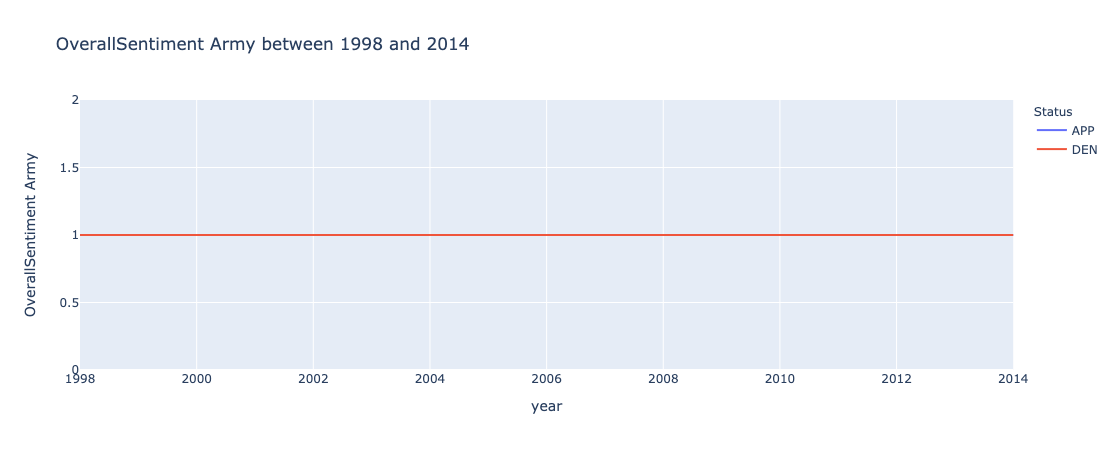

In [36]:
Image(filename = "./sentiment_analysis_plots/sentimentarmy.png")

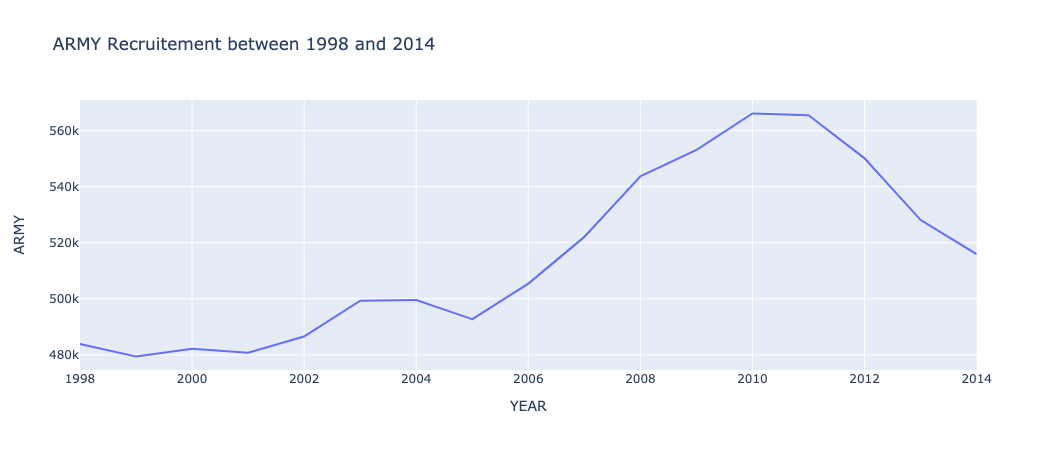

In [37]:
Image(filename = "./sentiment_analysis_plots/armyrecruitment.png")

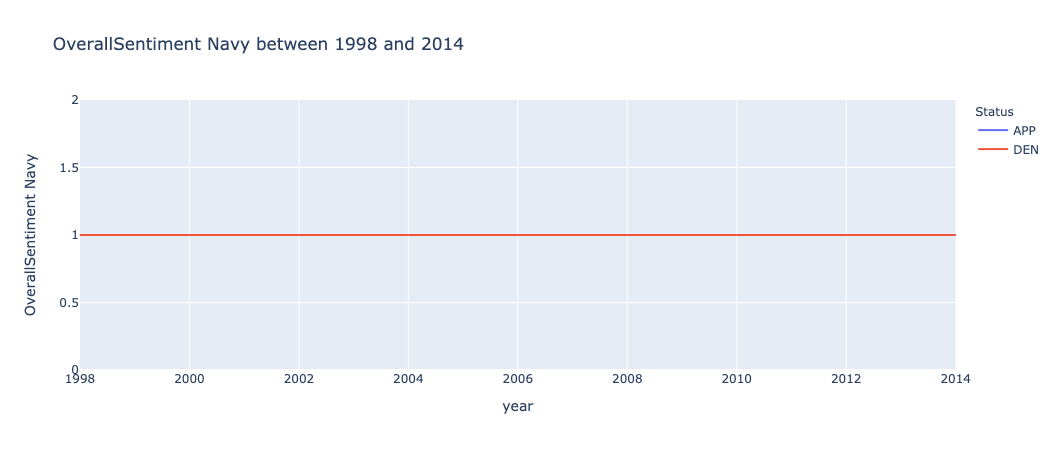

In [38]:
Image(filename = "./sentiment_analysis_plots/sentimentnavy.png")

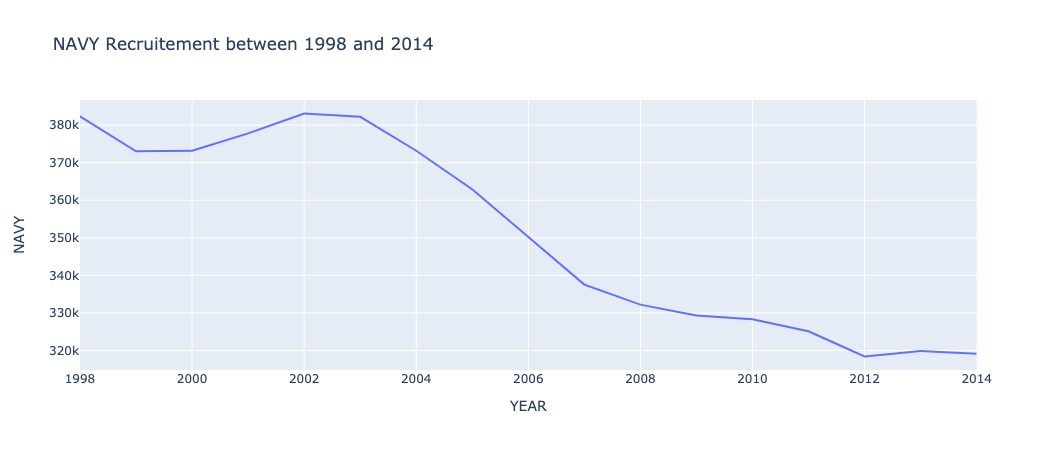

In [39]:
Image(filename = "./sentiment_analysis_plots/navyrecruitment.png")

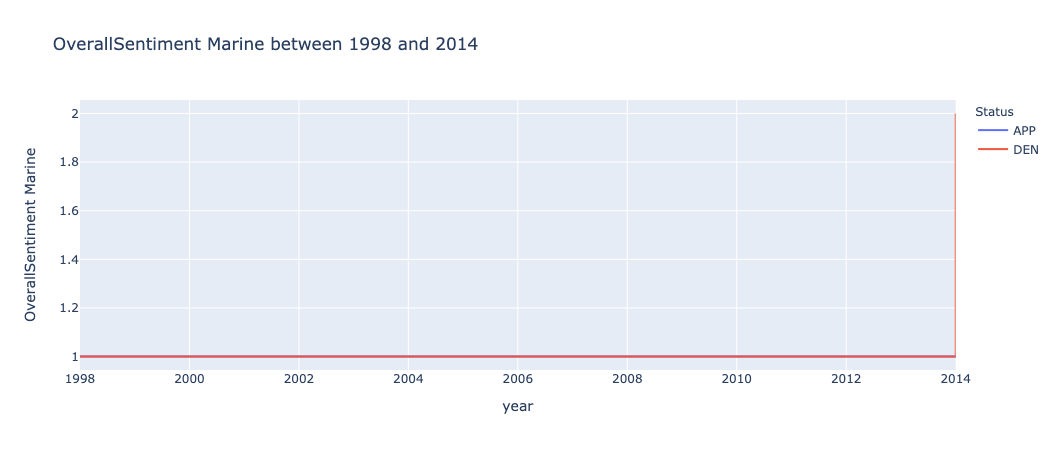

In [40]:
Image(filename = "./sentiment_analysis_plots/sentimentmarine.png")

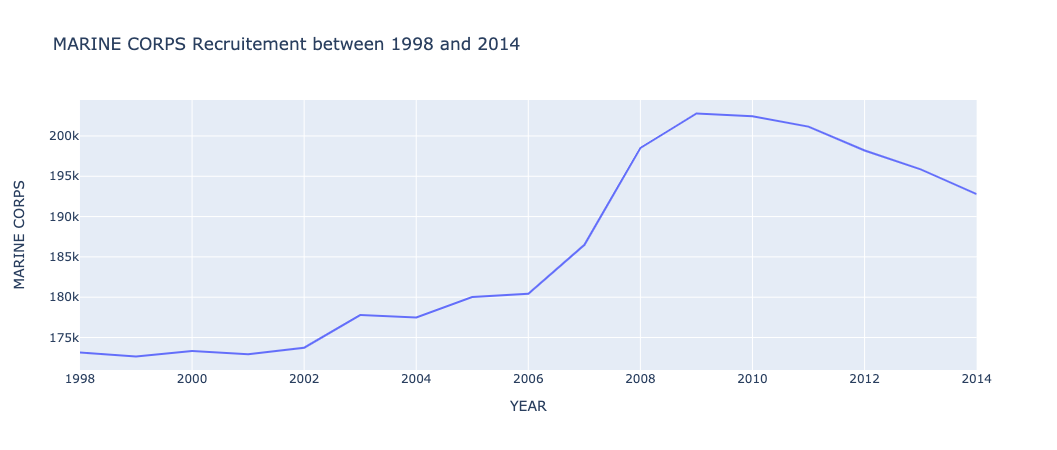

In [41]:
Image(filename = "./sentiment_analysis_plots/marinerecruitment.png")

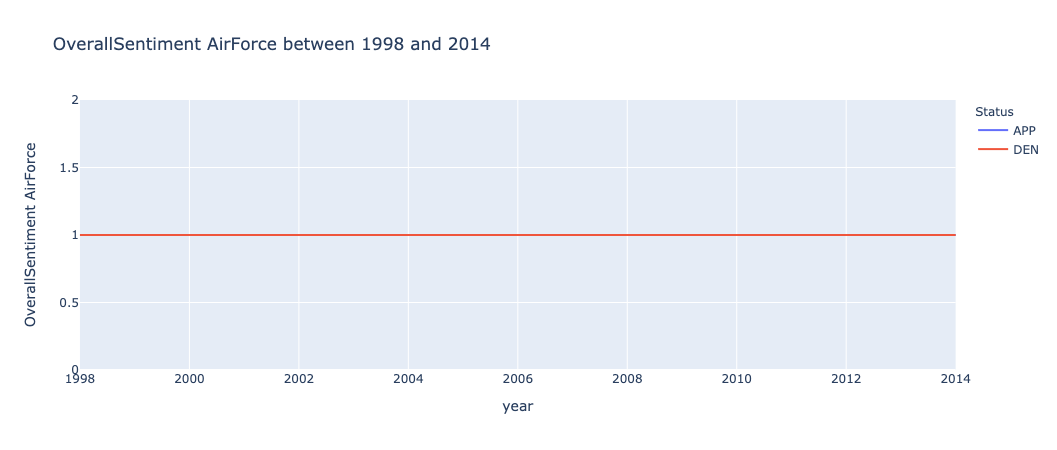

In [42]:
Image(filename = "./sentiment_analysis_plots/sentimentairforce.png")

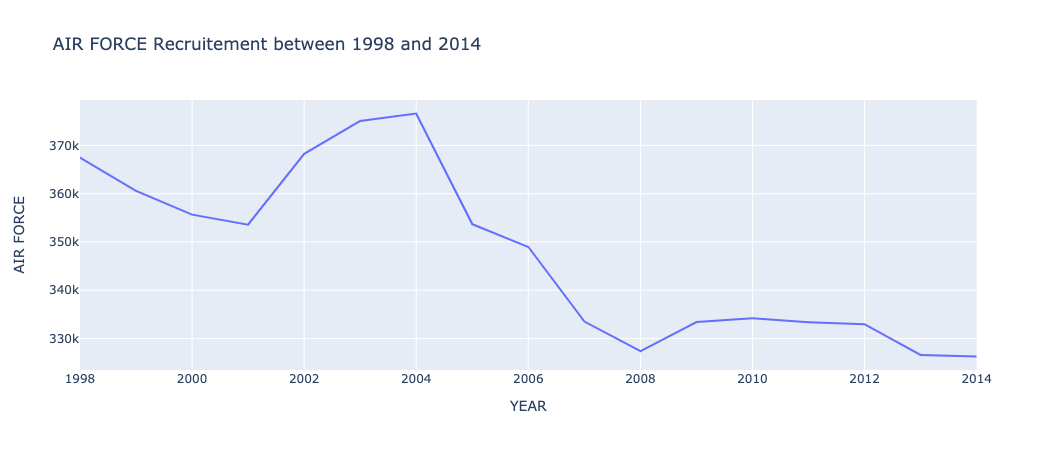

In [43]:
Image(filename = "./sentiment_analysis_plots/airforcerecruitment.png")

Between 1998 and 2014, movies' reviews shows a negative sentiment for Army aspect for both DoD supported and not supported movies. We cannot simply relate the ABSA results with the army recruitment numbers shown in the line graph above. Same as for the movies' reviews Navy aspect. In fact, we cannot relate the ABSA results with the recruitment numbers for none of the aspects above. There might be several reasons for that. For example, these reviewers might not live in the U.S. hence there is no sense to relate this results with the increasing number of recruitement. But here, we can assume that majority of them are from the U.S. and hence we assume that the dataset is representative of U.S. (because of the lack of data we cannot prove that). The other important factor is the data itself. We cannot just simply think that increase in the recruitment numbers is resulted from the postivie reviews. There are for sure other factors which affect this rise in the recruitment number.

In case you want to see the overall recrutiment numbers, here is the line plot for the total recruitement for all 4 aspects between 1998 and 2014.

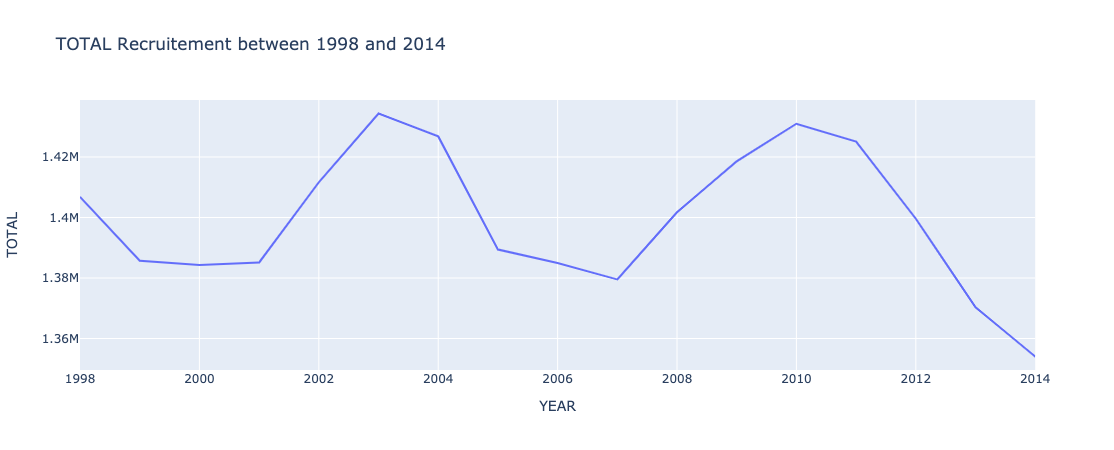

In [45]:
fig = px.line(militaryrecruitement, x="YEAR", y='TOTAL', title='TOTAL Recruitement between 1998 and 2014')
#fig.show()
Image(filename = "./sentiment_analysis_plots/recruitmenttotal.png")

__References:__

1. [Aspect-Based Sentiment Analysis Using Spacy & TextBlob](https://towardsdatascience.com/aspect-based-sentiment-analysis-using-spacy-textblob-4c8de3e0d2b9)
2. [Aspect Based Sentiment Analysis](https://github.com/ScalaConsultants/Aspect-Based-Sentiment-Analysis)